# Dataset conll04

This dataset is constructed from news articles and has 

In [1]:
import sys
sys.path.insert(0,'..')
import json
from abc import abstractmethod, ABC
from collections import OrderedDict
from logging import Logger
from typing import List
from tqdm import tqdm
from transformers import BertTokenizer

from spert import util, models, prediction,  sampling
from spert.entities import Dataset, EntityType, RelationType, Entity, Relation, Document
from spert.opt import spacy
from spert.evaluator import Evaluator
from spert.input_reader import JsonInputReader, BaseInputReader
from spert.loss import SpERTLoss, Loss
from spert.trainer import BaseTrainer
from spert.models import SpERT,SpROB, SpLONG

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from logging import raiseExceptions
import math
import os
from typing import Type
from unittest import case

import torch
from torch.nn import DataParallel
from torch.optim import Optimizer
import transformers
from torch.utils.data import DataLoader
from transformers import AdamW, BertConfig,RobertaConfig,LongformerConfig  
from transformers import BertTokenizer,RobertaTokenizer,LongformerTokenizer
from transformers import BertModel, RobertaModel,LongformerModel
from transformers import BertPreTrainedModel, RobertaPreTrainedModel,LongformerPreTrainedModel




## Entities and Relation Types
Both types are in file `conll04_types.json` and can be extracted as follows: 

In [2]:

types_path = "../data/datasets/conll04/conll04_types.json"

types = json.load(open(types_path), object_pairs_hook=OrderedDict)
entity_types = pd.DataFrame(types['entities']).transpose()
relation_types = pd.DataFrame(types['relations']).transpose()

relation_types

,short,verbose,symmetric
Work_For,Work,Work for,False
Kill,Kill,Kill,False
OrgBased_In,OrgBI,Organization based in,False
Live_In,Live,Live in,False
Located_In,LocIn,Located in,False


In [3]:
entity_types

,short,verbose
Loc,Loc,Location
Org,Org,Organization
Peop,Peop,People
Other,Other,Other


## Data Splits

The data are pre-split into train, train-dev, 

In [4]:
paths = ["../data/datasets/conll04/conll04_train.json",
         #"../data/datasets/conll04/conll04_train_dev.json",
         "../data/datasets/conll04/conll04_dev.json",
         "../data/datasets/conll04/conll04_test.json"]
#labels = ["train","train_dev","dev","test"]
labels = ["train","dev","test"]
data_splits = {}
for pth, label in zip(paths,labels):
    data_splits[label] = json.load(open(pth), object_pairs_hook=OrderedDict)
data_splits.keys()


dict_keys(['train', 'dev', 'test'])

In [5]:
ex1 = data_splits['test'][100]


The train-dev set is the union of train and dev as shown below:

In [7]:
[ "%s has %i examples"%(l,len(s)) for l,s in data_splits.items()]

['train has 922 examples', 'dev has 231 examples', 'test has 288 examples']

The size  of each train-dev example measured as token count:
 

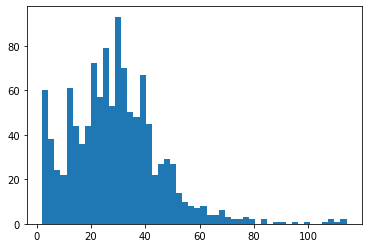

In [8]:
sizes = [len(ex['tokens']) for  ex in data_splits['train']+data_splits['dev'] ]
plot_bins = plt.hist(sizes, bins=50)
#plot_bins

In [14]:
seq1 = data_splits['train'][200]['tokens']

In [15]:
from transformers import RobertaTokenizer
bertTok = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=False,cache_dir=None,do_basic_tokenize=False)
robTok  = RobertaTokenizer.from_pretrained('roberta-base')
print(seq1)
print(bertTok.encode_plus(seq1))
print(robTok.encode_plus(seq1))


['MEMPHIS', ',', 'Tenn', '.']
{'input_ids': [101, 100, 1010, 100, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 3, 6, 34141, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [17]:
mtypes = ['spert','sprob']
model_names = []
configs = []
tokenizers = []
spmodels = []
for mtype in mtypes:
    model_class = models.get_model(mtype)

    if mtype == 'spert':
        model_name = 'bert-base-cased'
        config = BertConfig.from_pretrained(model_name, cache_dir=None)
        tokenizer = BertTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
    elif mtype == 'sprob':
        model_name = 'roberta-base'
        tokenizer = RobertaTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
        config = RobertaConfig.from_pretrained(model_name, cache_dir=None)
    elif mtype == 'splong':
        model_name = 'allenai/longformer-base-4096'
        tokenizer = LongformerTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
        config = LongformerConfig.from_pretrained(model_name, cache_dir=None)
    else:
        raise Exception("Argument model_type must be one of %s"%['spert','sprob','splong'])

    util.check_version(config, model_class, model_name)
    config.spert_version = model_class.VERSION
    print(model_name,config.spert_version)
    model = model_class.from_pretrained(model_name,
                                    config=config,
                                    # SpERT model parameters
                                    #cls_token=self._tokenizer.convert_tokens_to_ids('[CLS]'),
                                    cls_token=tokenizer.cls_token_id,
                                    relation_types=4,
                                    entity_types=5,
                                    max_pairs=1000,
                                    prop_drop=0.1,
                                    size_embedding=25,
                                    freeze_transformer=False,
                                    cache_dir=None
                                    )

    model_names.append(model_name)
    tokenizers.append(tokenizer)
    configs.append(config)
    spmodels.append(model)


bert-base-uncased 1.1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing SpERT: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing SpERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SpERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SpERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['entity_classifier.weight', 'size_embeddings.weig

roberta-base 1.1


Some weights of the model checkpoint at roberta-base were not used when initializing SpROB: ['roberta.encoder.layer.11.attention.self.key.bias', 'roberta.encoder.layer.5.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.encoder.layer.6.attention.self.value.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.self.query.bias', 'roberta.encoder.layer.7.intermediate.dense.bias', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.6.attention.output.LayerNorm.bias', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.4.output.dense.weight', 'roberta.encoder.layer.8.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.5.output.LayerNorm.weight', 'roberta.encoder.layer.6.output.dense.bias', 'rober

In [100]:
bert_name = 'bert-base-cased'
roberta_name = 'roberta-base'
bert_config = BertConfig.from_pretrained(bert_name, cache_dir=None)
roberta_config = RobertaConfig.from_pretrained(roberta_name, cache_dir=None)

bert_model = BertModel.from_pretrained(bert_name, config=bert_config)
roberta_model = RobertaModel.from_pretrained(roberta_name,config=roberta_config)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_

In [122]:
bert_model.encoder.layer[8]
bert_model.init_weights()

In [120]:
for x in roberta_model.encoder.layer[8].attention.self.query.parameters():
    print(x)

Parameter containing:
tensor([[-0.0265,  0.0737, -0.0082,  ..., -0.0157, -0.0316,  0.0314],
        [ 0.0321, -0.0354, -0.0954,  ..., -0.0011, -0.0240, -0.0122],
        [-0.0243,  0.0090, -0.0421,  ...,  0.0460, -0.0162,  0.0854],
        ...,
        [ 0.0386,  0.0914,  0.0159,  ..., -0.0410,  0.0346,  0.0068],
        [ 0.0914,  0.0981,  0.0704,  ...,  0.0023, -0.0318, -0.1753],
        [ 0.0071, -0.0322,  0.0246,  ..., -0.0684,  0.0122, -0.1757]],
       requires_grad=True)
Parameter containing:
tensor([ 3.7750e-02,  3.2135e-02, -1.2207e-01,  9.4604e-02, -1.7109e-03,
         6.4758e-02,  9.3506e-02,  5.4108e-02, -2.3773e-02, -5.9357e-02,
        -1.8280e-02, -3.1677e-02,  3.8013e-01,  1.0252e-03,  4.6356e-02,
         2.5711e-02, -3.3844e-02, -1.9608e-02,  7.9651e-02, -3.7079e-02,
        -9.8816e-02, -8.4656e-02,  1.2421e-01,  8.5327e-02, -1.2779e-03,
         6.8115e-02, -5.6580e-02,  1.7929e-02, -3.2013e-02, -1.5430e-01,
        -2.6880e-01, -1.3281e-01, -2.6733e-02,  6.0822e-0

In [79]:
print(spmodels[0].bert.encoder.layer[8])

RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): RobertaOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [121]:
#model.parameters().__dir__()
print(spmodels[1].bert.encoder.layer[8])

for x in spmodels[1].bert.encoder.layer[8].attention.self.query.parameters():
    print(x)

RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): RobertaOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
Parameter containing:
tensor([[-0.0040,  0.0210, -0.0024,  ...,  0.0039, -0.0284, -0.0032],
        [-0.011